# Quantum Volume

In [2]:
from qiskit_experiments.library import QuantumVolume
from qiskit_experiments.framework import BatchExperiment
from qiskit import transpile, execute
from qiskit.circuit.library import QuantumVolume as QuantumVolumeCircuit
from qiskit.quantum_info import Statevector

from fake_huayi37 import FakeHuayi37, FakeHuayi37V2
from fake_Huayi32 import FakeHuayi32, FakeHuayi32V2
from qiskit_ionq import IonQProvider
from qiskit.providers.fake_provider import *
from qiskit_aer.noise.noise_model import NoiseModel

from qiskit import Aer
from qiskit_aer import AerSimulator

import pandas as pd

## Use qiskit-experiments built-in QV measurement

**Error message**

Don't use V1 backend (including FakeHuayi12, FakeMontreal, ...)

something wrong with:

``transpiled_circuits = experiment._transpiled_circuits()``


There is also an unknown problem when n_qubits or trials is too big when use V2 backend

some discussions:

https://github.com/Qiskit-Extensions/qiskit-experiments/issues/846


In [ ]:
def collect_data(batch_data):
    results_table = pd.DataFrame()
    for i in range(batch_data.num_experiments):
        qv_result = batch_data.child_data(i).analysis_results("quantum_volume")
        data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
        results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)
    return results_table

In [ ]:
simulator_huayi = FakeHuayi37V2()
simulator_montreal = FakeMontrealV2()

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = [QuantumVolume(tuple(range(i)), trials=100) for i in range(3,7)]

# Batch the experiments (with different depth) into one object
batch_exp = BatchExperiment(exps)
batch_exp.set_transpile_options(optimization_level=3)

# Run with the specified backend
data_huayi = batch_exp.run(simulator_huayi).block_for_results()
data_montreal = batch_exp.run(simulator_montreal).block_for_results()

# Collect the results in the 'results_table'
results_huayi = collect_data(data_huayi)
results_montreal = collect_data(data_montreal)

# results_table = pd.DataFrame()
# for i in range(batch_exp.num_experiments):
#     qv_result = data_huayi.child_data(i).analysis_results("quantum_volume")
#     data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
#     results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)

display(results_huayi)
display(data_huayi.child_data(batch_exp.num_experiments-1).figure(0))

display(results_montreal)
display(data_montreal.child_data(batch_exp.num_experiments-1).figure(0))

In [ ]:
# Single run

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = QuantumVolume(tuple(range(4)), trials=160) 

# Batch the experiments (with different depth) into one object
exps.set_transpile_options(optimization_level=3)

backend = AerSimulator.from_backend(FakeMontrealV2())
# Run with the specified backend
expdata = exps.run(backend).block_for_results()

expdata.figure(0)

## Using method from qiskit textbook

https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/measuring-quantum-volume.ipynb

Procedure:

1. Set ``ncircuits`` and ``nshots``, sweep ``depth``
2. Generate ``ncircuits`` random circuits with SU(4) gates -> ideal simulation\
   ``ideal_heavy_outputs`` list of most likely 50% output states
3. For each random SU(4) ``circuit``, transpile with the noise model.\
   ``real_counts`` simulation outputs, formatted as (output state, counts)
4. If an ``output state`` is in ``ideal_heavy_outputs``, then ``N_heavy += counts``

Finally, ${\rm HOP} = N_{\rm heavy} / N_{\rm shots} N_{\rm circs} $

Standard deviation, $\sigma = \sqrt{{\rm HOP}(1-{\rm HOP})/N_{\rm circs} }$ (as defined in the textbook, no $N_{\rm shots}$ ?)

Criteria of success: ${\rm HOP} - 2\sigma > 2/3$

Quantum Volume: 256
Percentage Heavy Outputs: 76.9%
Passed?: True



(0.5, 1.0)

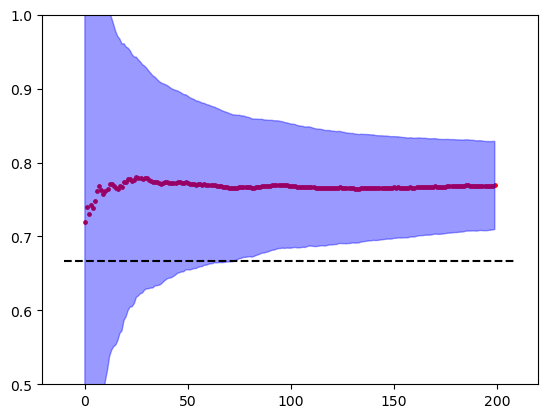

In [76]:
# Single test 

from quantum_volume import test_qv
from huayi_providers.fake_Quantinuum_lower import FakeQuantinuum_Lower, FakeQuantinuum_LowerV2

ncircuits = 200
nshots = 100

result, qv_circs, tr_circs = test_qv(FakeQuantinuum_Lower(), 8, ncircuits=ncircuits, nshots=nshots)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.scatter(range(ncircuits), result["cum_HOP"], s=6, c='r')
ax.fill_between(range(ncircuits), 
                np.array(result["cum_HOP"]) - np.array(result["cum_2sigma"]), 
                np.array(result["cum_HOP"]) + np.array(result["cum_2sigma"]), color='b', alpha=0.4)
ax.hlines(2/3, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='k')
ax.set_ylim([0.5,1])


In [ ]:
# Sweep depth

import os
import json
import pandas as pd

if not os.path.isdir("./QV_test"):
    os.mkdir("./QV_test")

from fake_Huayi32 import FakeHuayi32
from fake_Huayi37 import FakeHuayi37

def qv_for_depth(backend, depths, n_circuits, n_shots, filename):

    results_df = pd.DataFrame()

    for depth in depths:
        result, qv_circs, tr_circs = test_qv(backend, 
                                             depth, 
                                             ncircuits=n_circuits, 
                                             nshots=n_shots)
        results_df = pd.concat([results_df, 
                                pd.DataFrame(result, 
                                             columns=["backend", "n_qubits", "QV", "HOP", "success", "n_circuits", "n_shots", "2sigma"], 
                                             index=[0])],
                               ignore_index=True)
        qv_export = result | {"QV_circuits": [c.qasm() for c in qv_circs]} | {"transpiled_circuits": [c.qasm() for c in tr_circs]}
        
        with open("QV_test/{0}_{1}.json".format(filename, depth), 'w') as f:
            json.dump(qv_export, f)

    return results_df

n_circuits = 500
n_shots = 100
depths = range(2, 9)

results_32 = qv_for_depth(FakeHuayi32(), depths, n_circuits, n_shots, f"QV_{FakeHuayi32().name()}")
results_37 = qv_for_depth(FakeHuayi37(), depths, n_circuits, n_shots, f"QV_{FakeHuayi37().name()}")

display(results_32)
display(results_37)


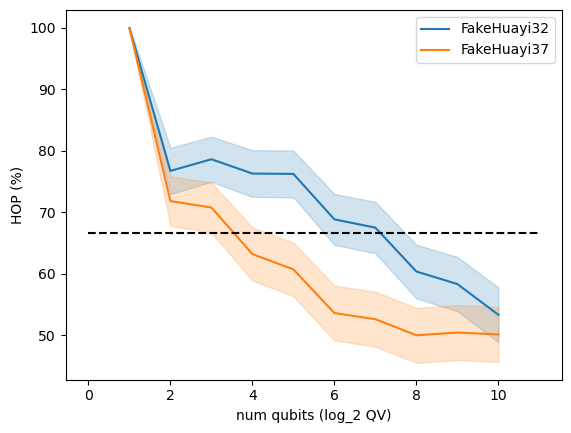

In [88]:
# Plot some tested results
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

drange = range(1,11)

fig = plt.figure()

for backend in ["FakeHuayi32", "FakeHuayi37"]:
    hop = []
    h_low = []
    h_high = []
    for d in drange:
        with open(f"QV_test/QV_{backend}_{d}.json", 'r') as f:
            data = json.load(f)
            hop.append(data['HOP'])
            h_low.append(data['HOP'] - data['2sigma'])
            h_high.append(data['HOP'] + data['2sigma'])
    p_hop = plt.plot( drange, hop, label=backend )
    p_err = plt.fill_between( drange, h_low, h_high, color=p_hop[0].get_color(), alpha=0.2)
    plt.legend()

plt.hlines(2/3*100, drange[0]-1, drange[-1]+1, color='k', linestyle='dashed' )
plt.xlabel('num qubits (log_2 QV)')
plt.ylabel('HOP (%)')
plt.show() 

            
